In [12]:
import scipy
import scipy.io
import scipy.integrate
import scipy.signal
from scipy.signal import argrelextrema
import numpy as np
from numpy import linalg
from pydmd import DMD
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
import math

In [24]:
#mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A0PIVairfoil.mat')
mat = scipy.io.loadmat('D:\Documents\Year 3\FEEG3003 - IP\Airfoil Data\A0PIVuv.mat')

data = list(mat.items())

u = data[7]
v = data[7]
u_mean = data[9]
x = data[10]
y = data[11]
ts = data[3][1][0][0] # time step between snapshots
print(data[7][0],data[8][0])
print(data[9][0],data[10][0])
print(data[11][0],data[12][0])

u v
u_mean v_mean
x y


In [19]:
samples = len(u[1])             # number of snapshots in input data

h = len(u[1][1][1])             # height of matrix = y
l = len(u[1][1])                # length of matrix = x
h_trunc = 35                    # y truncation for input data
l_trunc = 130                   # x truncation for input data
n_modes = 10
t_trunc = samples                  # number of time snapshots for SVD
size = h_trunc*l_trunc
# t = np.linspace(0, t_trunc, ts) #time scale

print(h,l,samples)

66 186 3499


In [20]:
#print(x[1]) # [name "x"] __ [186 x coord arrays] __ [66 identical values]
xs = []
for i in range(0, l_trunc):
    xs.append(x[1][i][1])
print(len(xs))
ys = y[1][1][0:(h_trunc)]
print(len(ys))
print(len(xs)*len(ys))
xsgrid, ysgrid = np.meshgrid(xs, ys)

130
35
4550


In [ ]:
X = np.empty([samples,h_trunc,l_trunc])
print(np.shape(X))
for i in range(0,samples/2):
    X_man = np.rot90(u[1][i]-u_mean[1][0],3)
    X_man = np.delete(X_man, np.s_[h_trunc::], 0) # from top left, slice row 0:h. Parameter of 0 in np.delete defines rows
    X_man = np.delete(X_man, np.s_[0:l-l_trunc], 1) # from top left, slice column 0:l. Parameter of 1 in np.delete defines columns
    X[i] = np.fliplr(X_man)

fig, ax = plt.subplots()
cs = ax.contourf(X[samples-1])
ax.set_title('Snapshot of X - verify truncation')
plt.plot()
fig.canvas.draw()

In [6]:
X = np.reshape(X, (samples,l_trunc*h_trunc))      # reshape X to contain all velocity points in second matrix dimension

X_trunc = np.transpose(np.delete(X, np.s_[t_trunc::], 0))   # truncate time resolution
print(np.shape(X_trunc))

(4550, 3499)


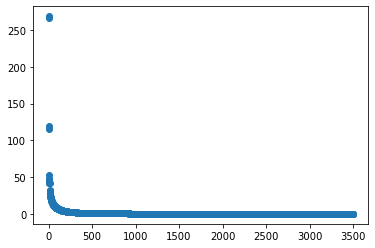

In [7]:
fig = plt.plot(scipy.linalg.svdvals(np.array([i.flatten() for i in X_trunc]).T), 'o')

In [8]:
dmdX = DMD(svd_rank=n_modes, tlsq_rank=0, exact=True, opt=True) #svd_rank of 0 auto-selects truncation rank. In some cases, 
#singular values should be examined in order to select the proper truncation.

dmdX.fit(X_trunc)

D:\Anaconda3\lib\site-packages\pydmd\dmdbase.py:348: UserWarning: Input data matrix X has condition number 3420674989973897.5. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn(
D:\Anaconda3\lib\site-packages\pydmd\dmdbase.py:348: UserWarning: Input data matrix X has condition number 3419622467486162.5. Consider preprocessing data, passing in augmented data matrix, or regularization methods.
  warnings.warn(


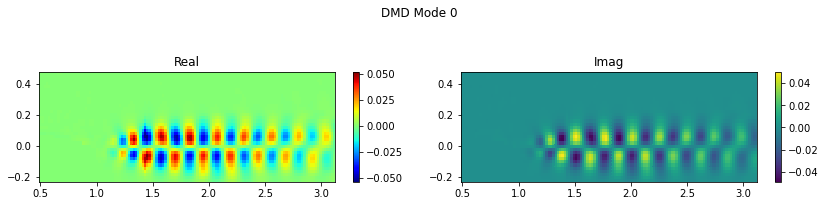

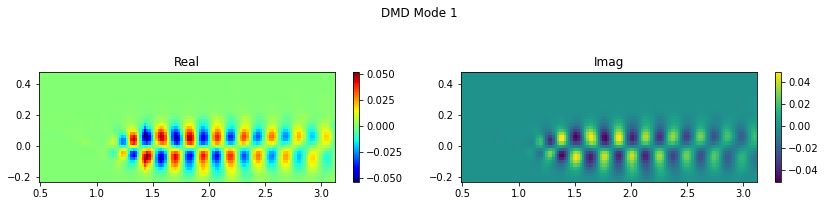

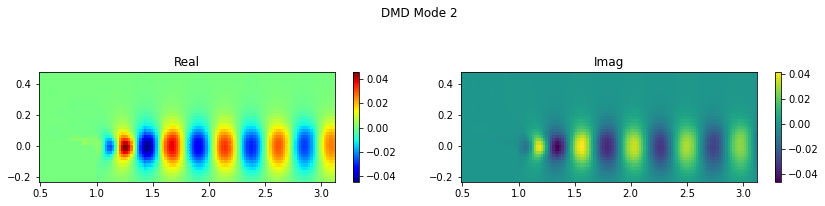

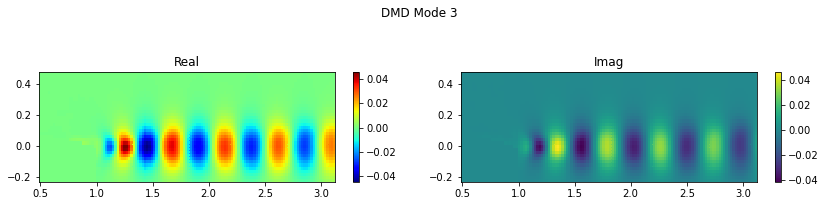

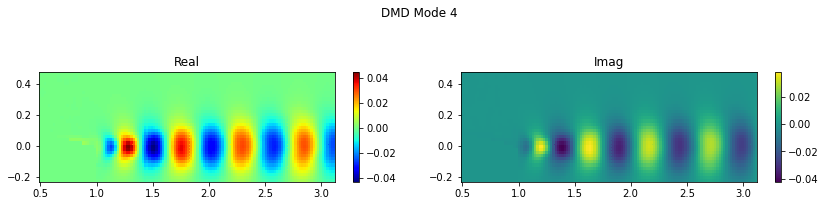

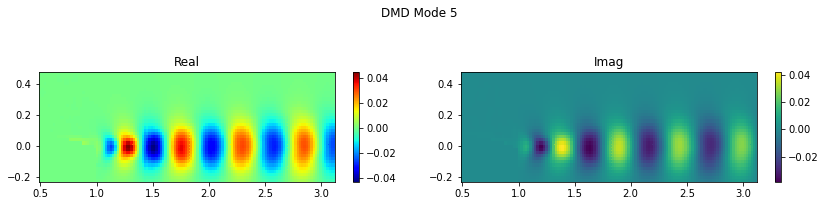

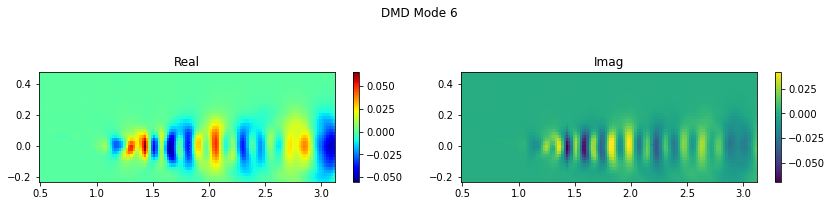

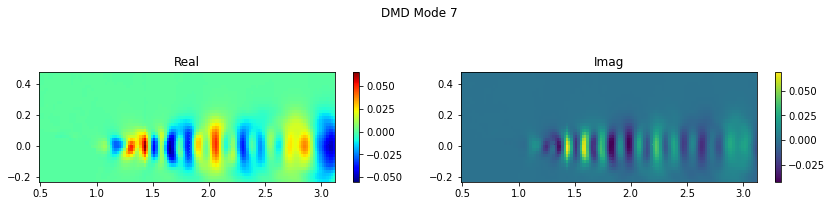

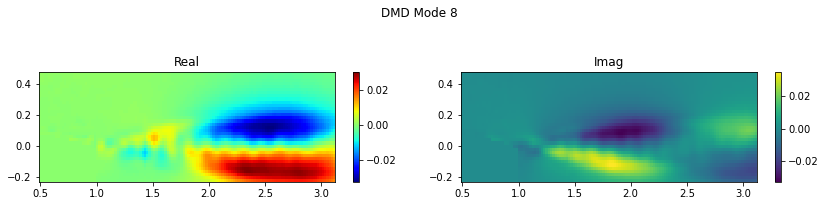

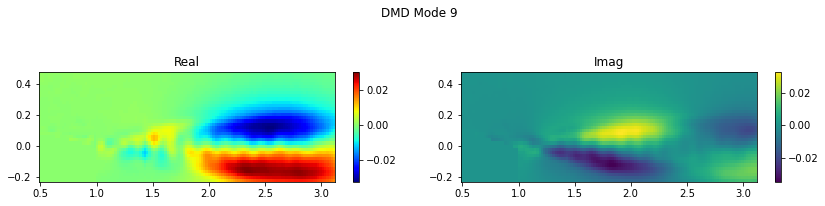

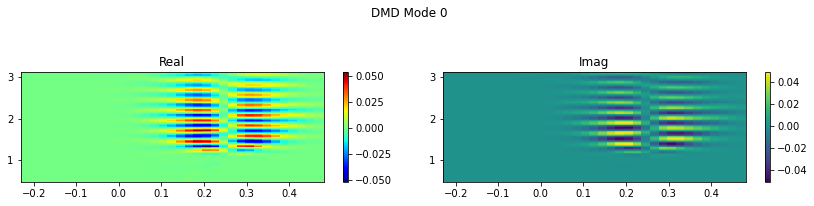

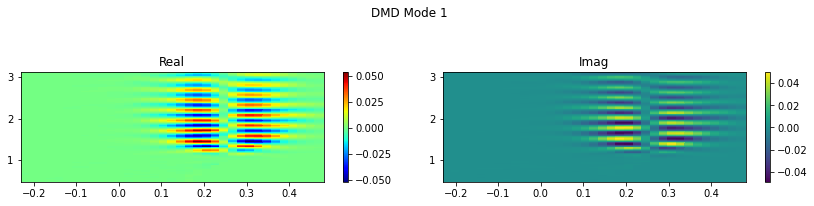

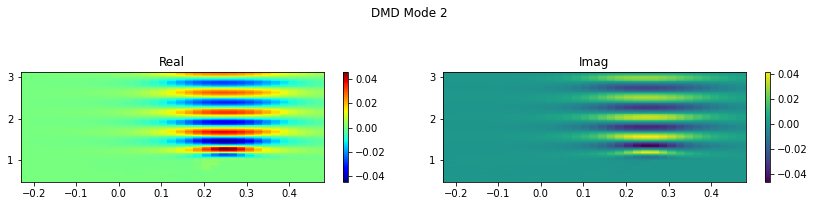

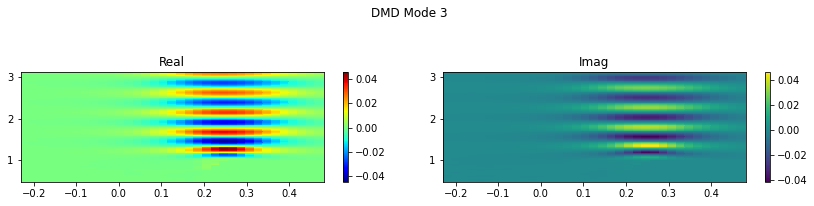

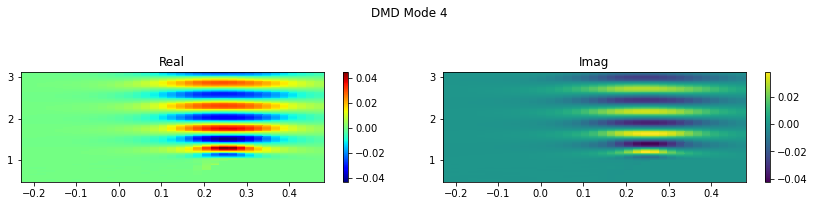

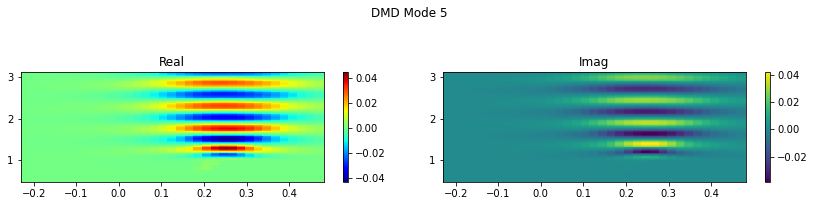

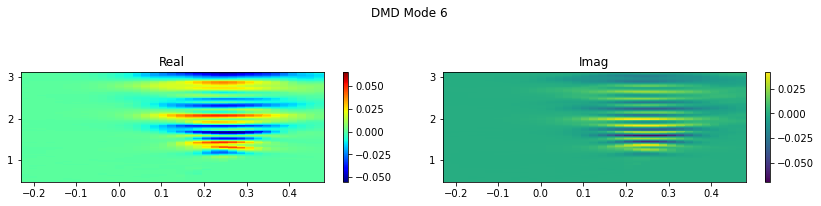

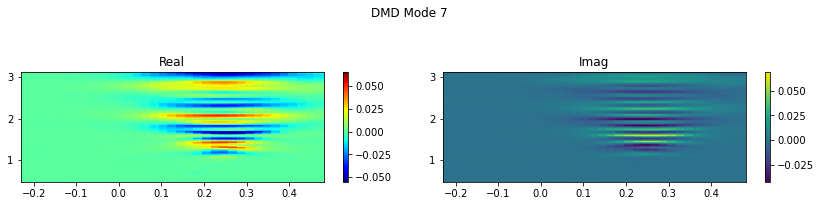

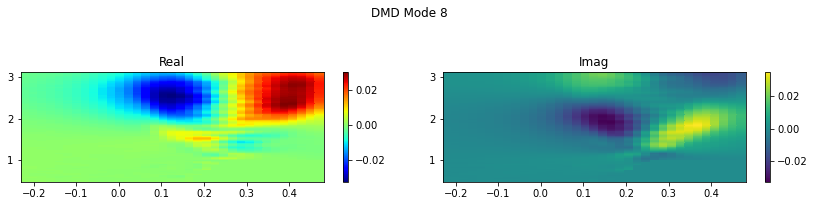

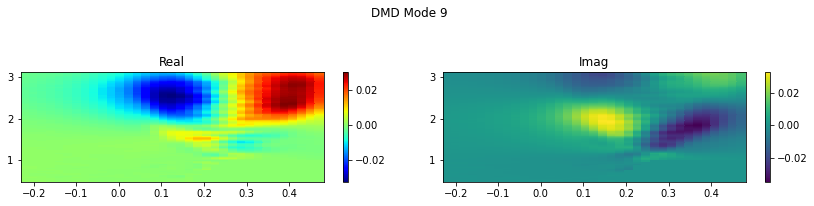

In [10]:
dmdX.plot_modes_2D(x=xs, y=ys, figsize=(12,3))

In [11]:
import csv
filename = "dmd_0both.csv"
with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerows(np.rot90(dmdX.modes.real))
    csvwriter.writerows(np.rot90(dmdX.modes.imag))

In [ ]:
for eig in dmd.eigs:
    print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(eig.imag**2+eig.real**2 - 1)))

dmd.plot_eigs(show_axes=True, show_unit_circle=True)

In [ ]:
for mode in dmd.modes.T:
    plt.plot(mode.real)
    plt.title('Modes')
plt.show()

t = np.linspace(0, samples*ts, samples)
i=0
for dynamic in dmd.dynamics:
    plt.ylim(-4.5, 4.5)
    plt.xlim(0, 5)
    plt.plot(t, dynamic.real, label='Mode '+str(i+1))
    plt.title('Dynamics')
    i = i+1
plt.xlabel('Time (s)')
plt.ylabel('Relative Amplitude')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [ ]:
# Source: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.04-FFT-in-Python.html
from numpy.fft import fft, ifft # using fast fourier transform to find the discrete frequencies of the signal

#mode_no = [0,1,2,3,4,5]
mode_no = [5,6,7,8,9,9]

Freq0 = np.flip(fft(dmd.dynamics.real[mode_no[0]]))
Freq1 = np.flip(fft(dmd.dynamics.real[mode_no[1]]))
Freq2 = np.flip(fft(dmd.dynamics.real[mode_no[2]]))
Freq3 = np.flip(fft(dmd.dynamics.real[mode_no[3]]))
Freq4 = np.flip(fft(dmd.dynamics.real[mode_no[4]]))
Freq5 = np.flip(fft(dmd.dynamics.real[mode_no[5]]))

N = len(Freq0)
n = np.arange(N/2)
sr = 1/ts # sampling rate, Hz
t = np.arange(0,N/sr,ts)
# Get the one-sided specturm
n_oneside = int(N/2)+1
# get the one side frequency
f_oneside = n*2*np.pi*sr/(2*n_oneside)
xmax = 40 #sr

fig, (plt0,plt1,plt2,plt3,plt4,plt5) = plt.subplots(6, figsize = (6,15))
plt.rc('font', size=13) #controls default text size

plt0.plot(f_oneside, np.abs(Freq0[:n_oneside]), 'r')
plt1.plot(f_oneside, np.abs(Freq1[:n_oneside]), 'g')
plt2.plot(f_oneside, np.abs(Freq2[:n_oneside]), 'b')
plt3.plot(f_oneside, np.abs(Freq3[:n_oneside]), 'y')
plt4.plot(f_oneside, np.abs(Freq4[:n_oneside]), 'c')
plt5.plot(f_oneside, np.abs(Freq5[:n_oneside]), 'm')
#plt0.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt1.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt2.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt3.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt4.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
#plt5.set_xticks([0,xmax/8,xmax/4,xmax/2,xmax,sr/8,sr/4,sr/2])
plt0.set_xlim(0, xmax)
plt1.set_xlim(0, xmax)
plt2.set_xlim(0, xmax)
plt3.set_xlim(0, xmax)
plt4.set_xlim(0, xmax)
plt5.set_xlim(0, xmax)

plt0.set_xlabel('Frequency (Hz)')
plt0.set_ylabel('FFT Amplitude |VT(freq)|')
plt1.set_xlabel('Frequency (Hz)')
plt1.set_ylabel('FFT Amplitude |VT(freq)|')
plt2.set_xlabel('Frequency (Hz)')
plt2.set_ylabel('FFT Amplitude |VT(freq)|')
plt3.set_xlabel('Frequency (Hz)')
plt3.set_ylabel('FFT Amplitude |VT(freq)|')
plt4.set_xlabel('Frequency (Hz)')
plt4.set_ylabel('FFT Amplitude |VT(freq)|')
plt5.set_xlabel('Frequency (Hz)')
plt5.set_ylabel('FFT Amplitude |VT(freq)|')

plt0.set_title('Mode ' + str(mode_no[0]+1) + ' coefficient frequency')
plt1.set_title('Mode ' + str(mode_no[1]+1) + ' coefficient frequency')
plt2.set_title('Mode ' + str(mode_no[2]+1) + ' coefficient frequency')
plt3.set_title('Mode ' + str(mode_no[3]+1) + ' coefficient frequency')
plt4.set_title('Mode ' + str(mode_no[4]+1) + ' coefficient frequency')
plt5.set_title('Mode ' + str(mode_no[5]+1) + ' coefficient frequency')

plt.tight_layout()
plt.show()

In [ ]:
peaks = np.zeros(n_modes)
for i in range(0,n_modes):
    Freq = np.flip(fft(dmd.dynamics.real[i]))
    plt.plot(Freq)
    try:
        f = (argrelextrema(Freq, np.greater)[0][0]+argrelextrema(Freq, np.less)[0][0])/2*2*np.pi*sr/(2*n_oneside)
        if f < 100:
            peaks[i] = (f)
        else:
            peaks[i] = 0
    except:
        peaks[i] = 0
print(peaks, type(peaks))
plt.show()

np.savetxt('dmd_freqs_0.csv', peaks, delimiter = ',')